<a href="https://colab.research.google.com/github/MeghaPujamath/Reinforcement-Learning---DQN-for-cartpole-environment-/blob/main/DeepQNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
import torch
from torch import nn
import random
import gym
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image

In [118]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [119]:
torch.set_grad_enabled(True)

HyperParameters

In [120]:
batch_size = 32 #No of transitions that we sample from replay buffer while calculating gradients
n_episodes = 1001
discountFactor = 0.99
epsilon = 1.0
epsilonFactor = 10000
minEpsilon = 0.02
learning_rate = 0.001
buffer_size = 50000 #Max No of trqnsitions that we store before clearing out
min_replay_size = 1000 #No of transitions stored in replay buffer before we start computing gradients and training
target_update_fre = 1000 #no of steps that we update target paramters equal to online parameters
episode_length = 100
episode_durations = []

Initializing Env

In [121]:
env = gym.make('CartPole-v0')
# memory = deque(maxlen=buffer_size)
reward_buffer = deque([0.0], maxlen=100)

state_size = env.observation_space.shape
action_size = env.action_space.n

Model

In [122]:
class ModelNetwork(nn.Module):
  def __init__(self, env):
    super().__init__()
    input_features = int(np.prod(state_size))
    self.net = nn.Sequential(
        nn.Linear(input_features, 64), 
        nn.Tanh(),
        nn.Linear(64, action_size))

  def forward(self, x):
    return self.net(x)


Initialize online and target Network

In [123]:
main_net = ModelNetwork(env) #Main network is actually trained
target_net = ModelNetwork(env) #target network is used to generate target values or ground truth

target_net.load_state_dict(main_net.state_dict())
optimizer = torch.optim.Adam(main_net.parameters(), learning_rate)

In [124]:
class DQNAgent():
  def __init__(self):
    self.loss_fn = torch.nn.MSELoss()

  def act(self, state):
    # with torch.no_grad():
    state_t = torch.as_tensor(state, dtype=torch.float32) #converting state to torch tensor
    q_values = main_net(state_t.unsqueeze(0)) #Creating fake batch dimensions of 1

    max_q_index = torch.argmax(q_values, dim=1)[0]
    action = max_q_index.detach().item() # converting torch tensor to integer
    return action
  
  def trainNetwork(self, batch_size, minibatch):
    states = np.asarray([m[0] for m in minibatch])
    actions = np.asarray([m[1] for m in minibatch])
    rewards = np.asarray([m[2] for m in minibatch])
    next_states = np.asarray([m[3] for m in minibatch])
    dones = np.asarray([m[4] for m in minibatch])

    states_t = torch.as_tensor(states, dtype=torch.float32)
    actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
    rewards_t = torch.as_tensor(rewards, dtype=torch.float32).unsqueeze(-1)
    done_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
    next_states_t = torch.as_tensor(next_states, dtype=torch.float32)

    #Actual q values or ground truth from target network using next state
    target_q_values = target_net(next_states_t) 
    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
    targets = rewards_t + discountFactor*(1-done_t)*max_target_q_values
    # test = torch.tensor(targets, requires_grad=True)

    #Predicted q values from main network using current state
    q_values = main_net(states_t)
    # action_q_values, _ = torch.max(q_values, axis=1)
    action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)
    # test2 = torch.tensor(action_q_values, requires_grad=True)

    #Compute Losses
    # loss = nn.functional.smooth_l1_loss(action_q_values, targets)
    loss = self.loss_fn(action_q_values, targets)

    #Gradient Descent Step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

Initialize Replay buffer

In [125]:
class ReplayBuffer:
  def __init__(self, buffer_size=buffer_size):
    self.buffer_size = buffer_size
    self.buffer = deque(maxlen=self.buffer_size)
  
  def insert_replayBuffer(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))
  
  def sample_replayBuffer(self, batch_size):
    return random.sample(self.buffer, batch_size)
  
  def buffer_initialization(self, env, min_replay_size):
    state = env.reset()
    for _ in range(min_replay_size):
      action = env.action_space.sample()
      next_state, reward, done, _ = env.step(action)
      self.insert_replayBuffer(state, action, reward, next_state, done)

      state = next_state
      if done:
        state = env.reset()


In [126]:
def plot(values, # Episode Durations
         moving_avg_period,
         env=None): # 100 episodes moving average
    moving_avg = get_moving_average(moving_avg_period, values)
    # plt.figure(2)
    figure, axes = plt.subplots(1, 2, figsize=(21, 6),
                              gridspec_kw={'width_ratios': [4, 6],
                                           'wspace':0.025, 'hspace':0.025})

    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.clf()
    axes[0].set_title('Training...')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Duration')
    axes[0].plot(values)
    axes[0].plot(moving_avg)
    if env:
        axes[1].set_title('Cart Pole Rendering')
        axes[1].grid(False)
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        axes[1].imshow(env.render('rgb_array'))
    else:
        axes[1].set_axis_off()
    plt.pause(0.001)
    print(f"- Episodes: {len(values)}\n- {moving_avg_period} episodes moving avg: {moving_avg[-1]}")
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)

    if len(values) >= period: # we can't calculate moving average of a dataset
                            ## when the dataset is not at least as large as the
                            ## the period we want to caculate the moving average for

        moving_avg = values.unfold(dimension=0, # which returns a tensor that contains 
                                   size=period, # with a size equal to the period 
                                   step=1)\
                                   .mean(dim=1).flatten(start_dim=0)
                                   # containing all slices of 100 accross the original value tensor 
                                   ## taking the average of each of these slices
                                                        ## and flatten the tensor so that now
                                                        ## a moving average is equal to tensor
                                                        ## containing all 100 period moving average.

        # We then concatenate this resulting tensor to a tensor of zeros with a size
        ## equal to `period-1`. This is to show that the moving average for the first 
        ## `period-1` values is zero given the explanation we just gave a moment ago.
        ## So, if our period is `100`, then the first `99` values of the moving_avg
        ## tensor will be `0`, and then each value afterwards will be the actual 
        ## calculated `100-period` moving average. 
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        # if the values is not bigger of equal to the period
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()  

Main loop


 Episode 999 finished after 26 steps with reward 26.0 and avg reward 21.5025025025025


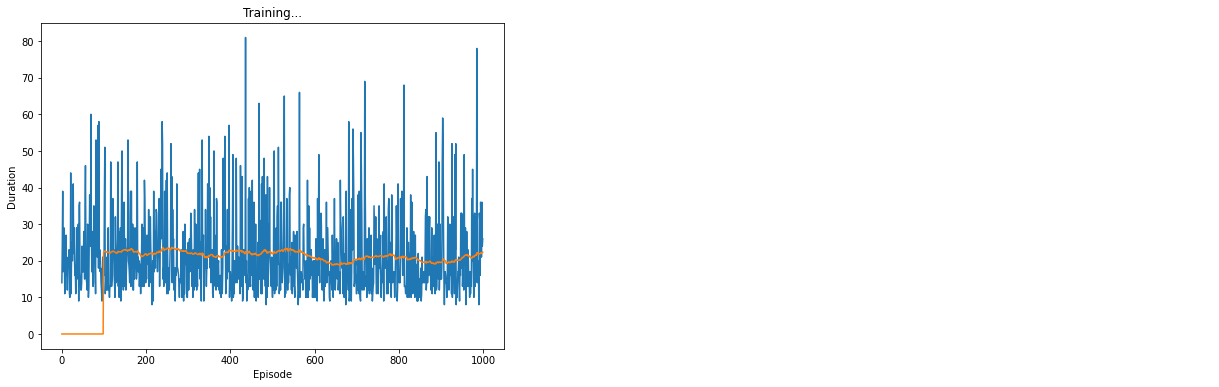

- Episodes: 1000
- 100 episodes moving avg: 22.329999923706055


In [127]:
agent = DQNAgent()
rb = ReplayBuffer()
rb.buffer_initialization(env, min_replay_size)
loss_test, losses_list, reward_list, episode_len_list, epsilon_list, mean_reward_list  = [], [], [], [], [], []
for episode in range(1000):
  episode_len, losses, episode_reward, steps = 0, 0, 0, 0
  state = env.reset()
  for i in itertools.count():
    # episode_len += 1

    #Choose action based on epsilon value, either exploring or exploiting
    action = env.action_space.sample()
    if torch.rand(1,).item() > epsilon:
      action = agent.act(state)
      
    next_state, reward, done, _ = env.step(action)
    rb.insert_replayBuffer(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward
    steps += 1

    miniBatch = rb.sample_replayBuffer(batch_size)
    loss = agent.trainNetwork(batch_size, miniBatch)
    losses += loss

    

    # if i%10 == 0:
    #   print()
    #   print('Step', i)
    #   print('Avg Reward', np.mean(reward_list))

    if done:
      # env.reset()
      print("{4} Episode {0} finished after {1} steps with reward {2} and avg reward {3}"
                  .format(episode, steps, episode_reward ,np.mean(reward_list), '\033[92m' if steps >= 195 else '\033[99m'))
      reward_list.append(episode_reward)
      episode_len += 1
      episode_durations.append(steps)
      plot(episode_durations, 100)
      losses_list.append(losses/episode_len)
      loss_test.append(losses)
      
      mean_reward_list.append(np.mean(reward_list))
      episode_len_list.append(episode_len)
      episode_reward = 0.0
      epsilon_list.append(epsilon)
      if epsilon > 0.05 :
        epsilon -= (1 / 5000)
      break
      # if(episode_len > 700):
      #   break
  if episode % target_update_fre== 0:
      target_net.load_state_dict(main_net.state_dict())
  if get_moving_average(100, episode_durations)[-1] >= 195:
        break

In [ ]:
epsilon_list

In [238]:
import seaborn as sns

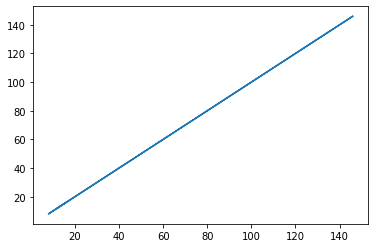

In [15]:
ve = []
for i,val in enumerate(reward_list):
  if(val == 200):
    ve.append(episode_len_list[i])

plt.plot(episode_len_list, reward_list)

In [ ]:
epsilon_list

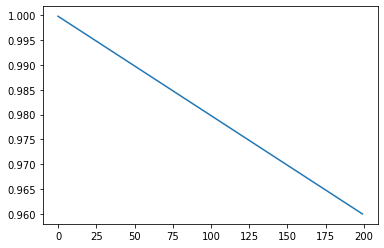

In [115]:
plt.figure(2)
plt.clf()
# durations_t = torch.tensor(reward_list, dtype=torch.float)
# plt.title('Megha...')
# plt.xlabel('Episode')
# plt.ylabel('Duration')
# #k = range(10000)
plt.plot(epsilon_list)
# plt.plot(epsilon_list)

# sns.scatterplot(x=np.arange(0, 20000), y=reward_list)


In [242]:

for i, val in enumerate(reward_list):
  if(val == 200):
    print(i)
    break

1410


In [228]:
k = range(20000)
op = list(map(lambda x, y: [x,y], k, reward_list)) 
print(op)

[[0, 13.0], [1, 17.0], [2, 16.0], [3, 31.0], [4, 16.0], [5, 11.0], [6, 42.0], [7, 13.0], [8, 16.0], [9, 49.0], [10, 16.0], [11, 15.0], [12, 56.0], [13, 21.0], [14, 21.0], [15, 15.0], [16, 15.0], [17, 21.0], [18, 21.0], [19, 24.0], [20, 23.0], [21, 16.0], [22, 43.0], [23, 21.0], [24, 20.0], [25, 17.0], [26, 16.0], [27, 17.0], [28, 13.0], [29, 43.0], [30, 23.0], [31, 20.0], [32, 11.0], [33, 22.0], [34, 22.0], [35, 10.0], [36, 18.0], [37, 21.0], [38, 12.0], [39, 22.0], [40, 32.0], [41, 25.0], [42, 24.0], [43, 56.0], [44, 18.0], [45, 14.0], [46, 11.0], [47, 20.0], [48, 34.0], [49, 19.0], [50, 23.0], [51, 13.0], [52, 21.0], [53, 27.0], [54, 16.0], [55, 14.0], [56, 41.0], [57, 15.0], [58, 19.0], [59, 13.0], [60, 24.0], [61, 30.0], [62, 20.0], [63, 17.0], [64, 19.0], [65, 15.0], [66, 15.0], [67, 18.0], [68, 10.0], [69, 20.0], [70, 32.0], [71, 14.0], [72, 21.0], [73, 13.0], [74, 26.0], [75, 33.0], [76, 65.0], [77, 42.0], [78, 12.0], [79, 33.0], [80, 19.0], [81, 25.0], [82, 49.0], [83, 12.0], [

In [230]:
count = 0
for i in op:
  if(i[1] == 200):
    count+=1

print(count)

13638


In [221]:
reward_list.count()

TypeError: ignored

In [ ]:
state = env.reset()
for _ in range(min_replay_size):
  action = env.action_space.sample()
  # ipdb.set_trace()
  # d = env.step(action)
  next_state, reward, done, _ = env.step(action)
  memory.append((state, action, reward, next_state, done))

  state = next_state
  if done:
    state = env.reset()

In [ ]:
def plot_durations(episode_durations):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

Training

In [ ]:
import torch
from torch import nn
import random
import gym
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

batch_size = 32 #No of transitions that we sample from replay buffer while calculating gradients
n_episodes = 1001
discountFactor = 0.99
epsilon = 1.0
epsilonFactor = 10000
minEpsilon = 0.02
learning_rate = 0.001
buffer_size = 50000 #Max No of trqnsitions that we store before clearing out
min_replay_size = 1000 #No of transitions stored in replay buffer before we start computing gradients and training
target_update_fre = 1000 #no of steps that we update target paramters equal to online parameters
episode_length = 100


env = gym.make('CartPole-v0')
memory = deque(maxlen=buffer_size)
reward_buffer = deque([0.0], maxlen=100)

state_size = env.observation_space.shape
action_size = env.action_space.n

class ModelNetwork(nn.Module):
  def __init__(self, env):
    super().__init__()
    input_features = int(np.prod(state_size))
    self.net = nn.Sequential(nn.Linear(input_features, 64), nn.Tanh(), nn.Linear(64, action_size))

  def forward(self, x):
    return self.net(x)

  def act(self, state):
    # with torch.no_grad():
    state_t = torch.as_tensor(state, dtype=torch.float32) #converting state to torch tensor
    q_values = main_net(state_t.unsqueeze(0)) #Creating fake batch dimensions of 1

    max_q_index = torch.argmax(q_values, dim=1)[0]
    action = max_q_index.detach().item() # converting torch tensor to integer
    return action

main_net = ModelNetwork(env) #Main network is actually trained
target_net = ModelNetwork(env) #target network is used to generate target values or ground truth

target_net.load_state_dict(main_net.state_dict())
optimizer = torch.optim.Adam(main_net.parameters(), learning_rate)


# class DQNAgent():
#   def __init__(self):
#     self.loss_fn = torch.nn.MSELoss()

#   def act(self, state):
#     # with torch.no_grad():
#     state_t = torch.as_tensor(state, dtype=torch.float32) #converting state to torch tensor
#     q_values = main_net(state_t.unsqueeze(0)) #Creating fake batch dimensions of 1

#     max_q_index = torch.argmax(q_values, dim=1)[0]
#     action = max_q_index.detach().item() # converting torch tensor to integer
#     return action
  
#   def trainNetwork(self, batch_size, minibatch):
#     states = np.asarray([m[0] for m in minibatch])
#     actions = np.asarray([m[1] for m in minibatch])
#     rewards = np.asarray([m[2] for m in minibatch])
#     next_states = np.asarray([m[3] for m in minibatch])
#     dones = np.asarray([m[4] for m in minibatch])

#     states_t = torch.as_tensor(states, dtype=torch.float32)
#     actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
#     rewards_t = torch.as_tensor(rewards, dtype=torch.float32).unsqueeze(-1)
#     done_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
#     next_states_t = torch.as_tensor(next_states, dtype=torch.float32)

#     #Actual q values or ground truth from target network using next state
#     target_q_values = target_net(next_states_t) 
#     max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
#     targets = rewards_t + discountFactor*(1-done_t)*max_target_q_values
#     # test = torch.tensor(targets, requires_grad=True)

#     #Predicted q values from main network using current state
#     q_values = main_net(states_t)
#     # action_q_values, _ = torch.max(q_values, axis=1)
#     action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)
#     # test2 = torch.tensor(action_q_values, requires_grad=True)

#     #Compute Losses
#     # loss = nn.functional.smooth_l1_loss(action_q_values, targets)
#     loss = self.loss_fn(action_q_values, targets)

#     #Gradient Descent Step
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     return loss.item()


state = env.reset()
for _ in range(min_replay_size):
  action = env.action_space.sample()
  # ipdb.set_trace()
  # d = env.step(action)
  next_state, reward, done, _ = env.step(action)
  memory.append((state, action, reward, next_state, done))

  state = next_state
  if done:
    state = env.reset()


losses_list, reward_list, episode_len_list, epsilon_list  = [], [], [], []
losses = 0
state = env.reset()
for i in range(2):
  for e in itertools.count():
    epsi = np.interp(e, [0, epsilonFactor], [epsilon, minEpsilon])
    if random.random() <= epsi:
      action = env.action_space.sample() #random action selection i.e exploring
    else:
      # ipdb.set_trace()
      action = main_net.act(state)

    next_state, reward, done, _ = env.step(action)
    memory.append((state, action, reward, next_state, done))

    state = next_state
    episode_reward += reward
    if done:
      state = env.reset()
      reward_buffer.append(episode_reward)
      episode_reward = 0.0


    minibatch = random.sample(memory, batch_size)

    states = np.asarray([m[0] for m in minibatch])
    actions = np.asarray([m[1] for m in minibatch])
    rewards = np.asarray([m[2] for m in minibatch])
    next_states = np.asarray([m[3] for m in minibatch])
    dones = np.asarray([m[4] for m in minibatch])


    states_t = torch.as_tensor(states, dtype=torch.float32)
    actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
    rewards_t = torch.as_tensor(rewards, dtype=torch.float32).unsqueeze(-1)
    done_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
    next_states_t = torch.as_tensor(next_states, dtype=torch.float32)

    target_q_values = target_net(next_states_t) #set of qvalues for each state. Each state has vast dimension and q values are dimension 1
    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

    targets = rewards_t + discountFactor*(1-done_t)*max_target_q_values

    #Compute Losses

    q_values = online_net(states_t)
    action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

    loss = nn.functional.smooth_l1_loss(action_q_values, targets)
    losses += loss.item()
    #Gradient Descent Step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # if done:
    #   episode_durations.append(e + 1)
    #   plot_durations()
    #   break

    #Update the Target Network
    if e % target_update_fre== 0:
      target_net.load_state_dict(online_net.state_dict())
    
    # losses_list.append(losses/e)
    reward_list = reward_buffer
    episode_len_list.append(e)
    epsilon_list.append(epsi)


    if e%10 == 0:
      print()
      print('Step', e)
      print('Avg Reward', np.mean(reward_buffer))

      # durations_t = torch.tensor(reward_list, dtype=torch.float)
      # plt.title('Training...')
      # plt.xlabel('Episode')
      # plt.ylabel('Duration')
      # plt.xlim([50, 300])
      # plt.plot(durations_t.numpy())
      
      # plt.show()

    # plot_durations(reward_list)
    
  # durations_t = torch.tensor(reward_list, dtype=torch.float)
  # plt.title('Training...')
  # plt.xlabel('Episode')
  # plt.ylabel('Duration')
  # plt.xlim([50, 300])
  # plt.plot(durations_t.numpy())
  
  # plt.show()


# print('Complete')
# env.render()
# env.close()
# plt.ioff()
# plt.show()


Step 0
Avg Reward 0.0

Step 10
Avg Reward 0.0

Step 20
Avg Reward 0.0

Step 30
Avg Reward 0.0

Step 40
Avg Reward 0.0

Step 50
Avg Reward 0.0

Step 60
Avg Reward 0.0

Step 70
Avg Reward 0.0

Step 80
Avg Reward 0.0

Step 90
Avg Reward 0.0

Step 100
Avg Reward 0.0

Step 110
Avg Reward 0.0

Step 120
Avg Reward 0.0

Step 130
Avg Reward 0.0

Step 140
Avg Reward 0.0

Step 150
Avg Reward 0.0

Step 160
Avg Reward 0.0

Step 170
Avg Reward 0.0

Step 180
Avg Reward 0.0

Step 190
Avg Reward 0.0

Step 0
Avg Reward 200.0


In [ ]:
env = gym.make('CartPole-v0')
env = gym.wrappers.Monitor(env, "record_dir")
for i in tqdm(range(2)):
    obs, done, rew = env.reset(), False, 0
    while (done != True) :
        A =  agent.get_action(obs, env.action_space.n, epsilon = 0)
        obs, reward, done, info = env.step(A.item())
        rew += reward
        sleep(0.01)
        env.render()  
    print("episode : {}, reward : {}".format(i,rew))

AttributeError: ignored

In [ ]:
# !pip install -Uqq ipdb
# import ipdb

# ipdb.set_trace()


In [ ]:
# !pip install pygame 

In [ ]:
# import os
# os.environ['SDL_VIDEODRIVER']='dummy'
# import pygame
# pygame.display.set_mode((640,480))

In [ ]:
# try:
#     os.environ["DISPLAY"]
# except:
#     os.environ["SDL_VIDEODRIVER"] = "dummy"